In [27]:
from distance.EuclideanDistance import EuclideanDistance
from utilities.visualization import Visualizer
from utilities.dataset_factory import DatasetFactory
import numpy as np
import keras
from CL_utilities import loss_function
import tensorflow as tf

# Hyperparameters

In [28]:
image_size = (100, 100)
epochs = 10
batch_size = 16
margin = 0.5
training_pairs = 2800
validation_pairs = 400
training_path = r"./data/FruitRecognition/Training"
validation_path = r"./data/FruitRecognition/Validation"

# Building training dataset 
# (1.) See Documentation to get info about structure of dataset

In [29]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(training_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(100, 100, 3)


2024-05-06 20:31:54.115052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


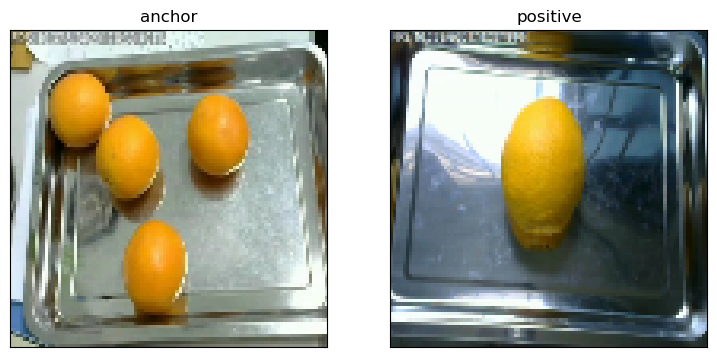

In [30]:
image, _ = next(iter(training_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

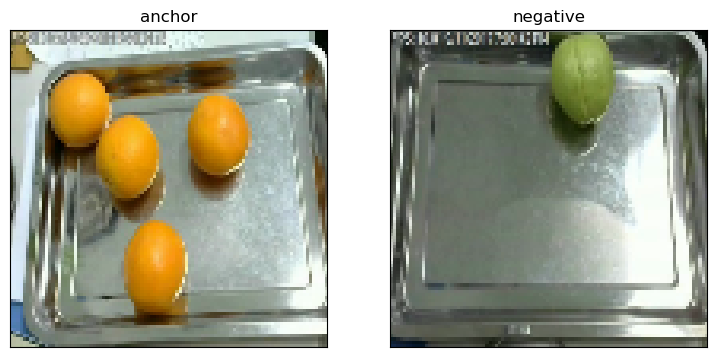

In [31]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

# Creating validation dataset

In [32]:
validation_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(validation_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(100, 100, 3)


2024-05-06 20:31:56.114538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


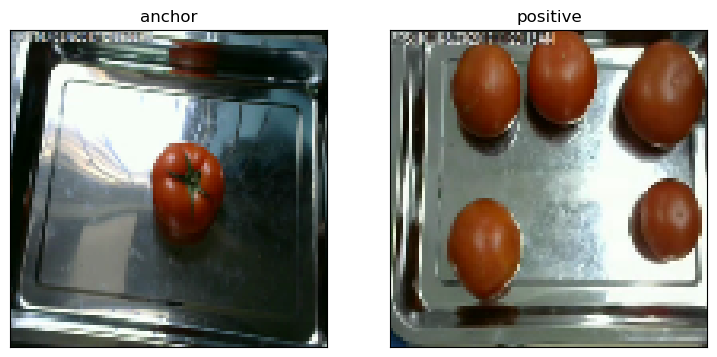

In [33]:
image, _ = next(iter(validation_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

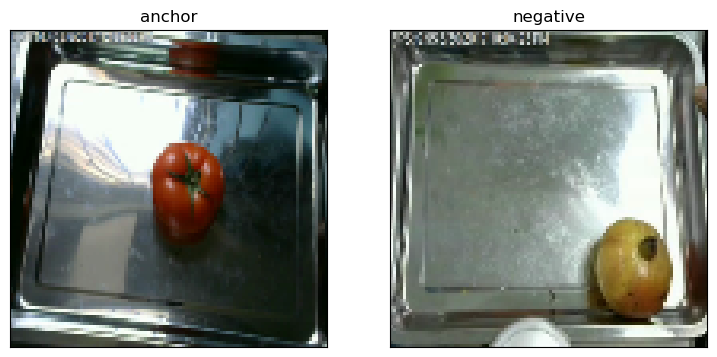

In [34]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

In [35]:
input_layer = keras.layers.Input((100,100,3))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(128, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
embedding_network = keras.Model(input_layer, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu


In [36]:
input_1 = keras.layers.Input(image_size + (3,))
input_2 = keras.layers.Input(image_size + (3,))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)
 
merge_layer = keras.layers.Lambda(EuclideanDistance(), output_shape=(1,))([tower_1, tower_2])
siamese = keras.Model(inputs=[input_1, input_2], outputs=merge_layer)

In [37]:
siamese.compile(loss=loss_function.loss(margin=margin), optimizer='adam', metrics=['accuracy'])
siamese.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_18 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_9 (Functional)           (None, 16)           915356      ['input_17[0][0]',               
                                                                  'input_18[0][0]']        

In [38]:
# How many samples we have, and how many we want in train and validation
# num_samples = sum(1 for _ in touple_of_products)
# train_size = int(0.8 * num_samples)
# val_size = num_samples - train_size
# # .take() to get from actual batch
# train_dataset = touple_of_products.take(train_size)
# val_dataset = touple_of_products.skip(train_size)

Trained_model_data = siamese.fit(training_dataset, 
                                 validation_data= validation_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs
                                )

Epoch 1/3
350/350 [==============================] - 133s 375ms/step - loss: 0.1982 - accuracy: 0.5629 - val_loss: 0.0590 - val_accuracy: 0.5052
Epoch 2/3
350/350 [==============================] - 130s 373ms/step - loss: 0.0518 - accuracy: 0.5502 - val_loss: 0.0443 - val_accuracy: 0.5664
Epoch 3/3
350/350 [==============================] - 131s 373ms/step - loss: 0.0454 - accuracy: 0.5748 - val_loss: 0.0391 - val_accuracy: 0.5530


In [39]:
# Loading Representatives from dataset_shop

camera_path = 'data/FruitRecognition/Shop_database'
paths = DatasetFactory.give_paths_to_test(camera_path, 10)

fruits_names = []
fruits_paths = []
fruits_names = [key.split('/')[-1] for key in paths.keys()]
fruits_paths = [value for value in paths.values()]  # Get 5 representatives for each class


In [40]:
#print(fruits_names)
#print(fruits_paths)

In [41]:
print((fruits_paths[0][4]))

data/FruitRecognition/Shop_database/muskmelon/Muskmelon 001223.png


In [42]:
import tensorflow as tf
from utilities.mapping import Mapper
list_of_images = []
list_of_labels = []
List_mean_feature_vector_shop = np.zeros((23,16))
i=0
j=0

for i in range(len(fruits_paths)):
    for j in range(5):
        path_to_image = Mapper(image_size)
        image = path_to_image._decode_and_resize(fruits_paths[i][j])
        list_of_images.append(image)
        list_of_labels.append(fruits_names[i])
    #print(list_of_labels)
        
    #___________________Get dimensions__________________________
    num_of_images = 5#len(list_of_images[0])  #one mean for each class
    size_feature_vector = embedding_network(tf.expand_dims(list_of_images[0], axis=0)).numpy()
    size_feature_vector = size_feature_vector.shape[1]   #get length
    #___________________________________________________________
    list_class_vectors = np.zeros((num_of_images, size_feature_vector))
        
    for num in range(5):
        list_class_vectors[num] = embedding_network(tf.expand_dims(list_of_images[num], axis=0)).numpy()
    #print(list_class_vectors)    
        
    mean_feature_vector = np.mean(list_class_vectors, axis=0)   # mean vector for all representatives of class
    
    List_mean_feature_vector_shop[i] = mean_feature_vector
    print(fruits_names[i])
    print(List_mean_feature_vector_shop[i])

    list_of_images.clear()
    list_of_labels.clear()
    
    

muskmelon
[0.         0.18701968 0.29255409 0.19062879 0.42373092 0.26663056
 0.08311613 0.00230175 0.         0.23859488 0.28918185 0.31979409
 0.39611784 0.         0.42033272 0.03079854]
Kiwi C
[0.         0.11200031 0.25206998 0.33515276 0.44690682 0.3070884
 0.00541679 0.         0.         0.28374922 0.33866559 0.28957271
 0.27296531 0.         0.39327037 0.07077022]
Apple A
[0.         0.00800811 0.37569751 0.41789738 0.41235695 0.03772068
 0.01297218 0.         0.         0.29230618 0.41396003 0.23894711
 0.1542292  0.         0.36759257 0.13582028]
Apple C
[0.         0.00274925 0.3272465  0.41183204 0.43609519 0.09303388
 0.00950001 0.         0.         0.28036701 0.39839009 0.26701389
 0.19021065 0.         0.39469845 0.11620418]
Carambola
[0.         0.16611301 0.29144734 0.10208627 0.44362682 0.19157492
 0.1416915  0.         0.00209204 0.22058899 0.25880636 0.38407108
 0.42674259 0.         0.4030369  0.00153312]
guava A
[0.         0.19034241 0.26057217 0.19080626 0.428

In [43]:
def distance_between_vectors(vector1, vector2):
    vector1 = vector1 / tf.norm(vector1)   # length ov vector == 1
    vector2 = vector2 / tf.norm(vector2)
    sum_square = np.sum(np.square(vector1 - vector2))
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

In [44]:
np.set_printoptions(precision=4)

distance1 = distance_between_vectors(List_mean_feature_vector_shop[0], List_mean_feature_vector_shop[16])
distance2 = distance_between_vectors(List_mean_feature_vector_shop[7], List_mean_feature_vector_shop[20])

print(f"Distance between {fruits_names[0]} and {fruits_names[16]}  == {distance1}")
print(f"Distance between {fruits_names[7]} and {fruits_names[20]}  == {distance2}\n")



Distance between muskmelon and Tomatoes  == 0.4610325427021597
Distance between guava B and Plum  == 0.3129367968542183


In [45]:
import random

camera_images_list = []
camera_labels_list = []
path_test_eff = 'data/FruitRecognition/Test'
data = DatasetFactory.give_paths_to_test(path_test_eff, 1)


# Losowo wybieranie 10 zdjęć z każdego folderu
camera_paths = [random.sample(paths_list, 10) for paths_list in data.values() if len(paths_list) >= 10]
camera_paths = [path for sublist in camera_paths for path in sublist]  # Spłaszczanie listy list
camera_names = [path.split('/')[-2] for path in camera_paths]  # Zakładam, że nazwa folderu jest właściwym labelem


camera_feature_vector = np.zeros((len(camera_paths), 16))
print(len(camera_paths))
# Dekodowanie i przetwarzanie obrazów
for i in range(len(camera_paths)):
    path_to_image1 = Mapper(image_size)
    img  = path_to_image1._decode_and_resize(camera_paths[i])
    camera_images_list.append(img)
    camera_labels_list.append(camera_names[i])  
    camera_feature_vector[i] = embedding_network(tf.expand_dims(camera_images_list[i],axis=0)).numpy()
    
# Obliczanie odległości między wektorami cech
distances = np.zeros(23)  # Zakładam, że istnieje 22 kategorie
for i in range(23):
    distances[i] = distance_between_vectors(camera_feature_vector, List_mean_feature_vector_shop[i])

230


In [46]:
def find_top_5(distances, labels):
    
    distances = np.array(distances)
    sorted_index = np.argsort(distances)
    top_5_idx = sorted_index[:5]
    
    top_5_distances = distances[top_5_idx]
    top_5_labels = [labels[i] for i in top_5_idx]

    return top_5_distances, top_5_labels

def give_efficiency(label_camera, top5_labels, top5_dist):
        top1 = 1.0 * bool(label_camera == top5_labels[0])
        top2 = 0.98 * bool(label_camera == top5_labels[1])
        top3 = 0.96 * bool(label_camera == top5_labels[2])
        top4 = 0.94 * bool(label_camera == top5_labels[3])
        top5 = 0.92 * bool(label_camera == top5_labels[4])
        
        sum = top1 + top2 + top3 + top4 + top5
        
        return sum  # return one of top1-top5 or 0 if there is no good prediction in top5

In [47]:
#def find_closest_topN():       # może być problem bo trzeba by było przekazywać te ogromne listy , będzie z tym problem (czy się zmieszczą)?
efficiency = 0.
eff_one_example = 0.
for num_camera_images in range(len(camera_paths)):  #230 (10 images for each class)
    for i in range(23):
        distances[i] = distance_between_vectors(camera_feature_vector[num_camera_images], List_mean_feature_vector_shop[i])
        #print(f"dystans ({camera_labels_list[num_camera_images]}) - ({list_of_labels[i]}) : {distances[i]}")
    top5_dist, top5_lab = find_top_5(distances, fruits_names)
    eff_one_example = give_efficiency(camera_names[num_camera_images], top5_lab, top5_dist)
    efficiency += eff_one_example
    if(eff_one_example <= 0.92):
        print(top5_lab)
        print(camera_names[num_camera_images])
        print(camera_paths[num_camera_images])
efficiency = efficiency/len(camera_paths)*100
print(f"Efficiency of model in our metric: {efficiency}")

['Carambola', 'Banana', 'Pomegranate', 'Pear', 'Mango']
muskmelon
data/FruitRecognition/Test/muskmelon/Muskmelon 00454.png
['Apple D', 'Apple F', 'muskmelon', 'guava A', 'guava B']
Kiwi C
data/FruitRecognition/Test/Kiwi C/Kiwi C00924.png
['Apple C', 'Plum', 'Peach', 'Tomatoes', 'Kiwi B']
Apple A
data/FruitRecognition/Test/Apple A/Apple 467.png
['Apple C', 'Plum', 'Kiwi B', 'Tomatoes', 'Apple A']
Apple A
data/FruitRecognition/Test/Apple A/Apple 350.png
['Plum', 'Kiwi B', 'Kiwi C', 'kiwi A', 'Apple C']
Apple A
data/FruitRecognition/Test/Apple A/Apple 571.png
['Plum', 'Apple C', 'Kiwi B', 'Tomatoes', 'Apple A']
Apple A
data/FruitRecognition/Test/Apple A/Apple 337.png
['Persimmon', 'Pitaya', 'Tomatoes', 'Orange', 'Peach']
Apple C
data/FruitRecognition/Test/Apple C/Apple Co applee08001.png
['Kiwi B', 'Kiwi C', 'Plum', 'kiwi A', 'Peach']
Apple C
data/FruitRecognition/Test/Apple C/scene04861.png
['Apple D', 'muskmelon', 'guava A', 'Apple F', 'guava B']
Carambola
data/FruitRecognition/Test/Car